In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import normalized_mutual_info_score
from sklearn import model_selection


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#                                          ::::PROJECT OBJECTIVES::::

1. Application of machine learning algorithms for successful classification of patients undergoing cancer treatment.
2. Application of feature engineering techniques.
3. Deploying Models with interpretability for the domain experts in cancer treatment.

In [2]:
import zipfile
import pandas as pd
data = pd.read_csv('../input/msk-redefining-cancer-treatment/training_variants.zip',compression='zip')
data.head()
data.shape[0]
data.shape[1]
data.columns.values

array(['ID', 'Gene', 'Variation', 'Class'], dtype=object)

In [3]:
import zipfile
data_text=pd.read_csv('../input/msk-redefining-cancer-treatment/training_text.zip',compression='zip',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print(data_text.head())
print(data_text.shape[0])
print(data_text.shape[1])


   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...
3321
2


Text Preprocessing
Here i have implemented the code to firstly remove any alphanumeric characters,repeated spaces and the stop words(words which does not mean much like prepositions,conjunctions etc.

In [4]:
import nltk
nltk.download('stopwords')
stop_word=set(stopwords.words('english'))

def nlp_preprocessing(totaltext,index,column):
    if (total_text) is not int:
        string=" "
    totaltext=re.sub('[a-zA-Z0-9\n]',' ',totaltext)
    totaltext=re.sub('\s+',' ',totaltext)
    totaltext=totaltext.lower()
    
    for word in total_text.split():
        if not word in stop_word :
            string += word +" "
            
    data_text[columns][index]=string
    for index,row in data_text.iteritems():
         nlp_preprocessing(row['TEXT'],index,'TEXT')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
result=pd.merge(data,data_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


All the nan values in text columns are being replaced by a combination of gene and variation feature. 

In [6]:
result[result.isnull().any(axis=1)]
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']


Here the data is splitted in 64-16-20 ratio between the train,crossvalidate and test data,using sklearn's train_test_split with stratify on the classes to be predicted to get an roughly equal distribution of the class labe;s among the train test and cross validate.

In [7]:
from sklearn.model_selection import train_test_split
y_true=result['Class'].values
result.Gene =result.Gene.str.replace('\s+','_')
result.Variation =result.Variation.str.replace('\s+','_')
X_train ,test_df,y_train,y_test= train_test_split(result,y_true,stratify=y_true,test_size=0.2)
train_df,cv_df,y_train,y_cv= train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


An analysis of how is the population of the given class labels as we can see that some classes have very less data points.
The key takeaway of the following distribuition is that class balancing can be useful to make the model predict the lower classes with a greater accuracy.

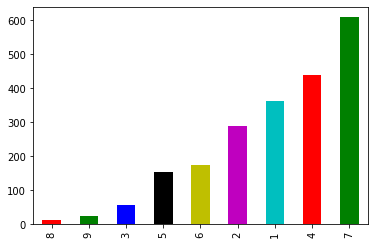

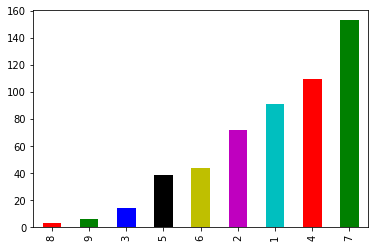

In [8]:
train_class_distribution=train_df['Class'].value_counts().sort_values()
test_class_distribution=test_df['Class'].value_counts().sort_values()
cv_class_distribution=cv_df['Class'].value_counts().sort_values()

my_colors=['r','g','b','k','y','m','c']
train_class_distribution.plot(kind='bar',color=my_colors)
plt.show()
sorted_yi = np.argsort(~train_class_distribution.values)


my_colors=['r','g','b','k','y','m','c']
cv_class_distribution.plot(kind='bar',color=my_colors)
plt.show()
sorted_yi = np.argsort(~cv_class_distribution.values)


Now i am going to do a very important data analysis by using confusion,precision and recall matrices
the precission and recall matrices are also very important as recall matrix tells us how many of the the points in a given class were corectly predicted this tells us how many were wrongly classified and in the precision matrix we try to see the perfection of our model and how much correctly our model predicted as here we sum by column,whereas in recall matrix we sum by row.

In [9]:
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    A=(((C.T)/(C.sum(axis=1))).T)
    B=(C/C.sum(axis=0))
    labels =[1,2,3,4,5,6,7,8,9]
    print("CONFUSION MATRIX")
    plt.figure(figsize=(20,7))
    sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted class')
    plt.ylabel('real class')
    plt.show()
    
    print("PRECISION MATRIX")
    plt.figure(figsize=(20,7))
    sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted class')
    plt.ylabel('real class')
    plt.show()
    
    print("RECALL MATRIX")
    plt.figure(figsize=(20,7))
    sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted class')
    plt.ylabel('real class')
    plt.show()
    

It is very important to make a random model first to understand and compare our main model with this one the values predicted by this model will be completely random and any improvement of decreasing the log loss and missclassified points will easily be seen in future models. So here is my random model.

log loss on CV 2.481056975270126
log loss on test 2.450747131329069
[[0.21673483 0.04670966 0.14913829 ... 0.10596334 0.12499381 0.12168335]
 [0.0783864  0.09456139 0.24306352 ... 0.0152695  0.11655163 0.09652589]
 [0.11117923 0.19838142 0.10787167 ... 0.03115093 0.10836968 0.2303117 ]
 ...
 [0.03442837 0.04813407 0.03391394 ... 0.17215254 0.15890496 0.11296396]
 [0.00349531 0.15037751 0.18935972 ... 0.23444692 0.04714417 0.16320358]
 [0.31096621 0.04264945 0.03854326 ... 0.09671216 0.21734051 0.05729713]]
CONFUSION MATRIX


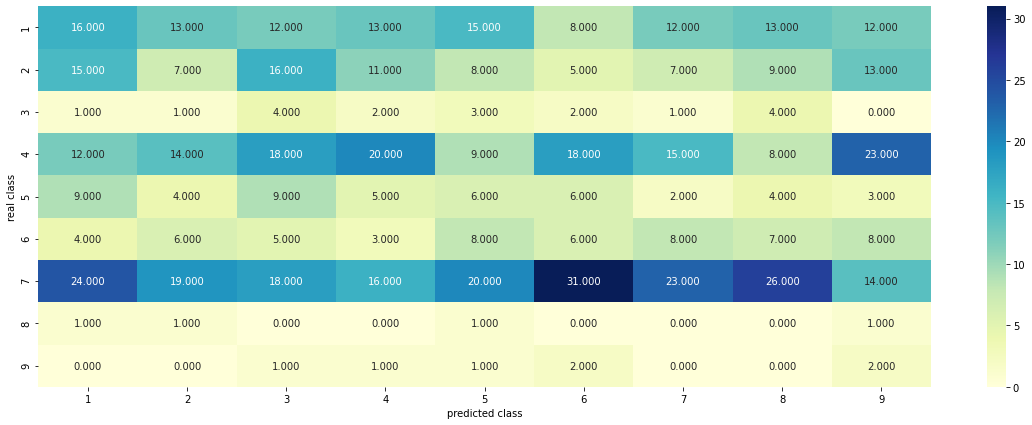

PRECISION MATRIX


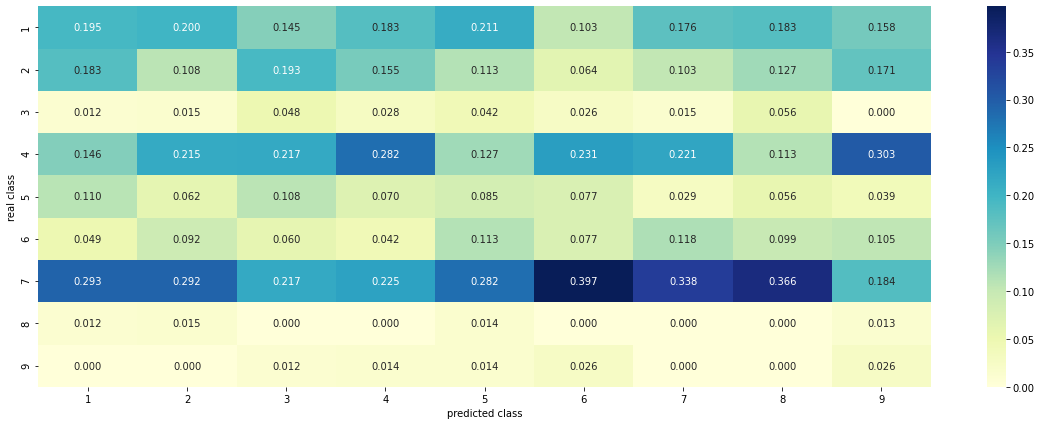

RECALL MATRIX


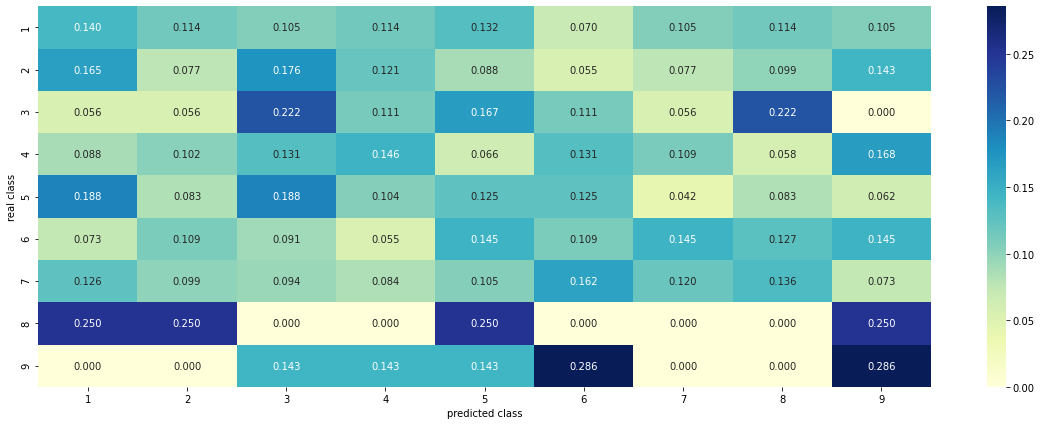

In [10]:
test_data_len=test_df.shape[0]
cv_data_len=cv_df.shape[0]
cv_predicted_y=np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs=np.random.rand(1,9)
    cv_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
    
test_predicted_y=np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs=np.random.rand(1,9)
    test_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
    
print("log loss on CV",log_loss(y_cv,cv_predicted_y))
print("log loss on test",log_loss(y_test,test_predicted_y))
print(test_predicted_y)
predicted_y=np.argmax(test_predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y+1)


Next step is to analyze each feature,firstly we take the Gene feature and try some exploratory data analysis we can see that cumulative distribution is as important as probability distribution as here we get to know the number of features which contain a large part of data point.

237


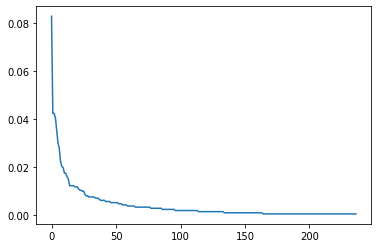

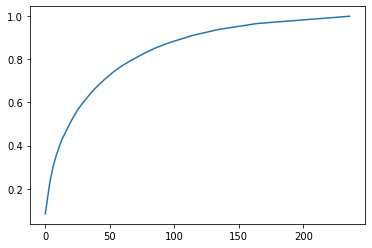

count    237.000000
mean       8.962025
std       17.743304
min        1.000000
25%        1.000000
50%        3.000000
75%        8.000000
max      176.000000
Name: Gene, dtype: float64

In [11]:
unique_genes=train_df['Gene'].value_counts()
print(unique_genes.shape[0])
s=sum(unique_genes.values);
h=unique_genes.values/s;
plt.plot(h,label="histogram")
plt.show()
c=np.cumsum(h)
plt.plot(c,label="cumulative frequency")
plt.show()
unique_genes.describe()

About 25 percent of gene categories occured more than 8 times.
and 50 percent of data occurs 3 times

As we have made our random model already we will easily be able to know the credibility of our model 
before running a full fledged it will be very helpful to run models on individual features so that we 
can decide whether to keep them in our main model it is important to analyze the importance of a particular 
feature and whether is contributes positively.



Now we are one hot encoding the Gene feature so that we can run our logistic regression model.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
alpha=1
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])
cv_gene_feature_onehotCoding
train_gene_feature_onehotCoding

<2124x236 sparse matrix of type '<class 'numpy.int64'>'
	with 2124 stored elements in Compressed Sparse Row format>

The most useful metric for calculating loss here can be log loss as we have a multiclass classification moreover the best way to analyze the performance of our model would be by a probabilistic technique as other loss metrics do not take the probability in account we would not be able to generalize loss for a point where probabilites were distributed quite close among classes and as the final label is selected by max of these probabilities we would not get the actual loss.
Hence we use the calibrated classifier.

SGDclassifier optimizer with logistic loss gives logistic regression model we can also use logistic regression from sklearn, l2 regularization is preferred.

Cross-validation has been kept in mind to reduce under/over-fitting of the model and the minimum log loss is found.

In [13]:
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print( "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print( "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print( "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1948946493174835
For values of alpha =  0.0001 The log loss is: 1.1755148460444538
For values of alpha =  0.001 The log loss is: 1.2276900174257745
For values of alpha =  0.01 The log loss is: 1.342995124680621
For values of alpha =  0.1 The log loss is: 1.4463900384498611
For values of alpha =  1 The log loss is: 1.481584279521333
The train log loss is: 0.9874856776346235
The cross validation log loss is: 1.1755148460444538
The test log loss is: 1.212827509986852


The model after running saw significant drops in the train,test,cross-validate log loss.It is important to compare logloss of train and cv to recheck if we have over-fitted the model,it was not encountered here(as all losses were roughly same) so we can conclude that our feature and model are suitable to build the final model.

It is important to notice the overlap of features between the train,test and cross-validate because as we are one-hot encoding it is sure that we miss some features. 

In [14]:

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
print(test_coverage/test_df.shape[0])
print(cv_coverage/cv_df.shape[0])

0.9759398496240601
0.9661654135338346


Here it is found that more than 95 percent of features overlapp.

*In this section we will analyze the credibility of variation feature.*

We begin with the analysis of frequency of each variation feature.

Number of Unique Variations : 1920


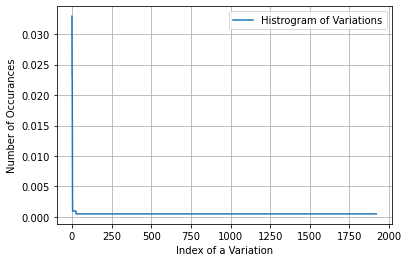

[0.03295669 0.05602637 0.07862524 ... 0.99905838 0.99952919 1.        ]


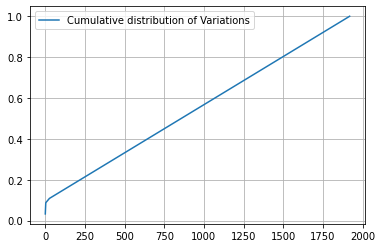

In [15]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

All ideas remain same as that during the gene feature analysis.

In [16]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])


In [17]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)
predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.715820562625402
For values of alpha =  0.0001 The log loss is: 1.7097376821950332
For values of alpha =  0.001 The log loss is: 1.707270142181615
For values of alpha =  0.01 The log loss is: 1.7138609712844148
For values of alpha =  0.1 The log loss is: 1.728219345645581
For values of alpha =  1 The log loss is: 1.729577289535631
For values of best alpha =  0.001 The train log loss is: 1.0433645312046036
For values of best alpha =  0.001 The cross validation log loss is: 1.707270142181615
For values of best alpha =  0.001 The test log loss is: 1.7334592665885293


This model also depicted drops in the train,test,cross-validate log loss Over/under-fit was not encountered here so we can inlude this feature for our final modelling.

In [18]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print((test_coverage/test_df.shape[0])*100)
print((cv_coverage/cv_df.shape[0])*100)


8.1203007518797
11.278195488721805


Overlapp amongst the train,cv,test was very high again.

*Analysis of text features*

Here as we have text data we have used TfidfVectorizer instead of CountVectorizer as the implementation of the former is better as it takes into account the number of times a word appered in the datapoint and in the whole data frame.
A very sparse matrix will be generated.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


Here I made the tfidf model only on the train data as it is important not to train it on cv or test data as it can lead to
feature leakage and will not be appropriate for a model that has to has to be useful.

In [20]:
cv_log_error_array=[]
beta = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1]

for i in beta:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print( "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))




best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print( "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print( "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print( "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The log loss is: 1.3556332081642068
The log loss is: 1.2910214015490942
The log loss is: 1.2251924603754123
The log loss is: 1.2618798975160723
The log loss is: 1.3868251796690825
The log loss is: 1.4856705542812005
The log loss is: 1.6393690126368423
The train log loss is: 0.5579146301491814
The cross validation log loss is: 1.2618798975160723
The test log loss is: 1.0651203159199947


A graph is being used to analyze the hyperparameter vs log-loss
Again this feature also counts a lot due to sharp decrease in the log loss and also it is not overfitting.

In [21]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

94.902 % of word of test data appeared in train data
96.467 % of word of Cross Validation appeared in train data


Here the overlap is very less nearly ten percent but still the model performed so well implying that this is a very powerful feature.

#      ::: Interpretability of the model:::
     
     
 Here we are defining functions for miss-classified points and logg-loss.
 Also the get_impfeature_name is afunction whic returns the features that were present int the point and there importance this will give the domain expert(pathologists in this case) an idea about the feature and the model will not be a blackbox.
 
This function will use the coefficient matrix(index sorted,which numerically contains feature importance) of an already trained model which is truncated depending upon the number of top features we want.

In [22]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")


We also look for another type of encoding know as response encoding in which each feature in one hot encoding is replaced by a 9-dimensional feature only based on probabilities.The total features will reduce to 27.

In [23]:
# making a dictionary which be later used in response coding storing the frequency of every word in data
from collections import Counter, defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))


total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [24]:
#RESPONSE CODING FOR GENE,VARIATION FEATURE
def get_gv_fea_dict(alpha, feature, df):
    
   
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        
        vec = []
        for k in range(1,10):
            

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea


#RESPONSE CODING FOR TEXT FEATURE

import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))


total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

Alpha is used for smoothing so as to prevent infinity or undetermined values.

In [25]:
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)
# Sum of row values to one
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T
# Normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


In [26]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


Stacking all the three features to make the final models.

In [27]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))



print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)


One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54418)
(number of data points * number of features) in test data =  (665, 54418)
(number of data points * number of features) in cross validation data = (532, 54418)


**BASELINE MODEL**

Multinomial NaiveBayes model will be our first model here.



In [28]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-05
Log Loss : 1.3120802315506317
for alpha = 0.0001
Log Loss : 1.3058024117579985
for alpha = 0.001
Log Loss : 1.2943068132454543
for alpha = 0.1
Log Loss : 1.3169853295955753
for alpha = 1
Log Loss : 1.2992686834369893
for alpha = 10
Log Loss : 1.417231022976511
for alpha = 100
Log Loss : 1.3484109786835623
for alpha = 1000
Log Loss : 1.3170176321733293
For values of best alpha =  0.001 The train log loss is: 0.8003275175893779
For values of best alpha =  0.001 The cross validation log loss is: 1.2943068132454543
For values of best alpha =  0.001 The test log loss is: 1.2303165677829415


Log Loss : 1.2943068132454543
Number of missclassified point : 0.38721804511278196


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


CONFUSION MATRIX


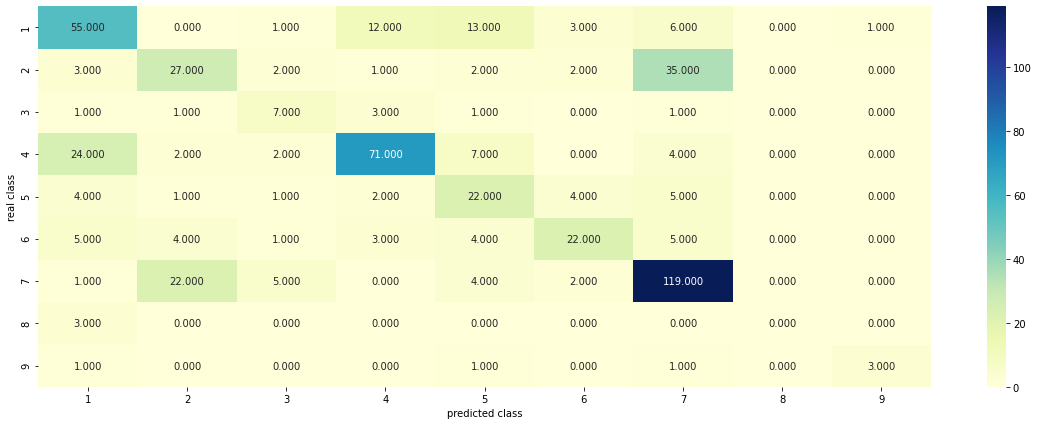

PRECISION MATRIX


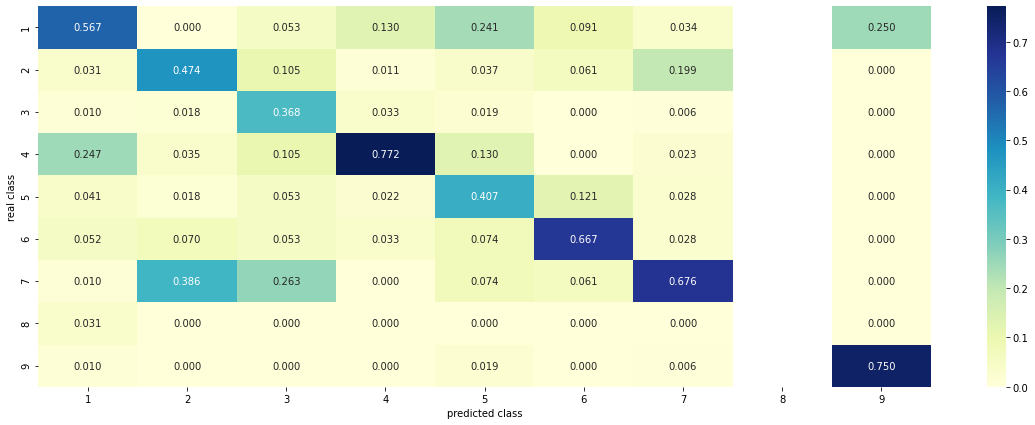

RECALL MATRIX


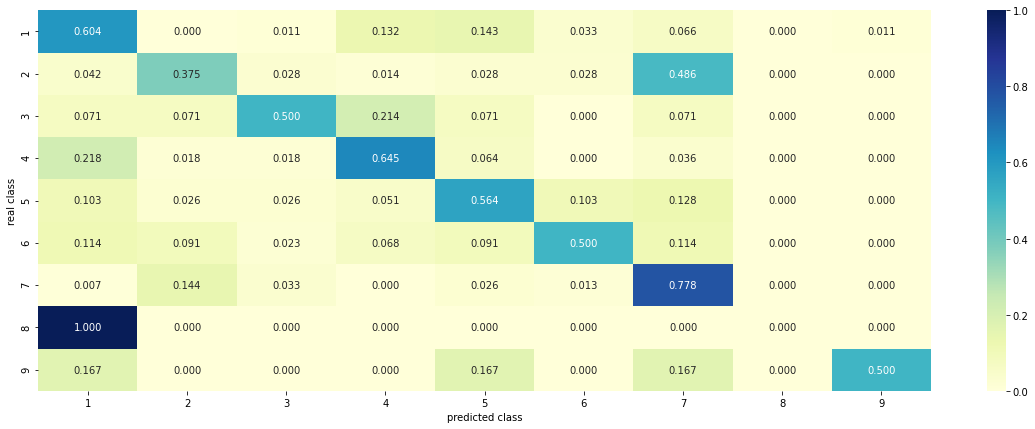

In [29]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))


Passing the indices and calling the feature importance prototype,for a predicted point.

In [30]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0825 0.0847 0.0104 0.1104 0.0367 0.0351 0.6309 0.0055 0.0039]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**K NEAREST NEIGHBORS**

for alpha = 5
Log Loss : 1.1779533664927555
for alpha = 11
Log Loss : 1.1187602070566416
for alpha = 15
Log Loss : 1.1247602828161083
for alpha = 21
Log Loss : 1.118674641559141
for alpha = 31
Log Loss : 1.120838570608824
for alpha = 41
Log Loss : 1.1238391029739472
for alpha = 51
Log Loss : 1.122112749195833
for alpha = 99
Log Loss : 1.1142939844219557


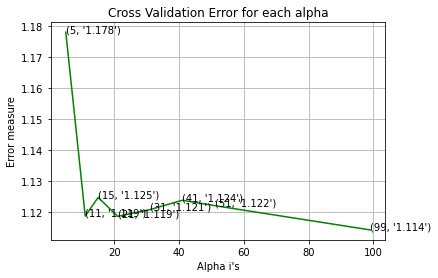

For values of best alpha =  99 The train log loss is: 0.9168518740031614
For values of best alpha =  99 The cross validation log loss is: 1.1142939844219557
For values of best alpha =  99 The test log loss is: 1.1206694110054607


In [31]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1142939844219557
Number of mis-classified points : 0.3966165413533835
CONFUSION MATRIX


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


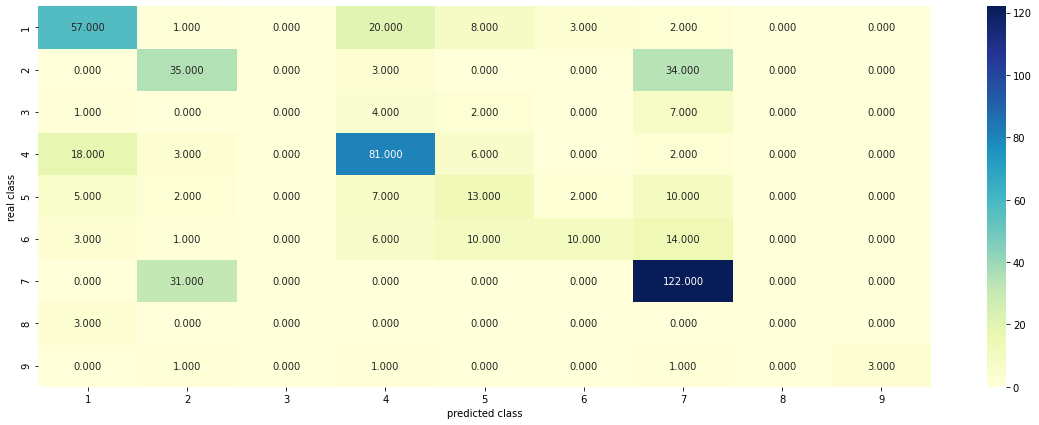

PRECISION MATRIX


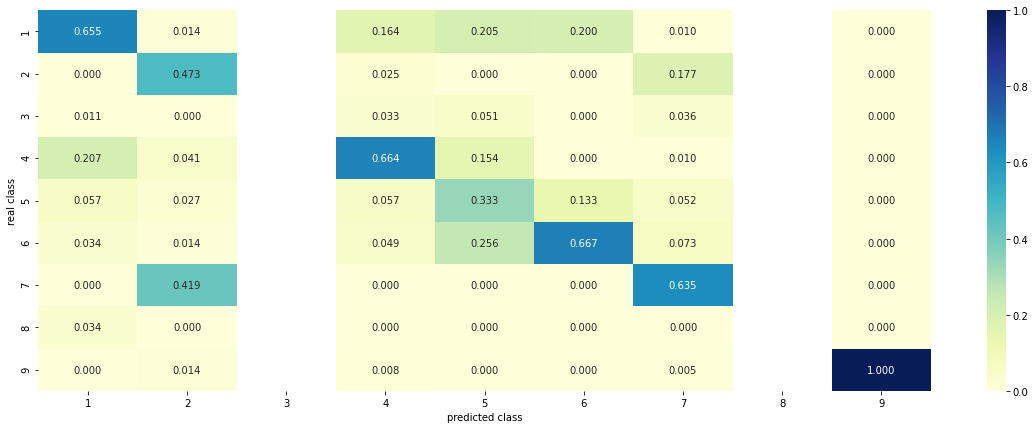

RECALL MATRIX


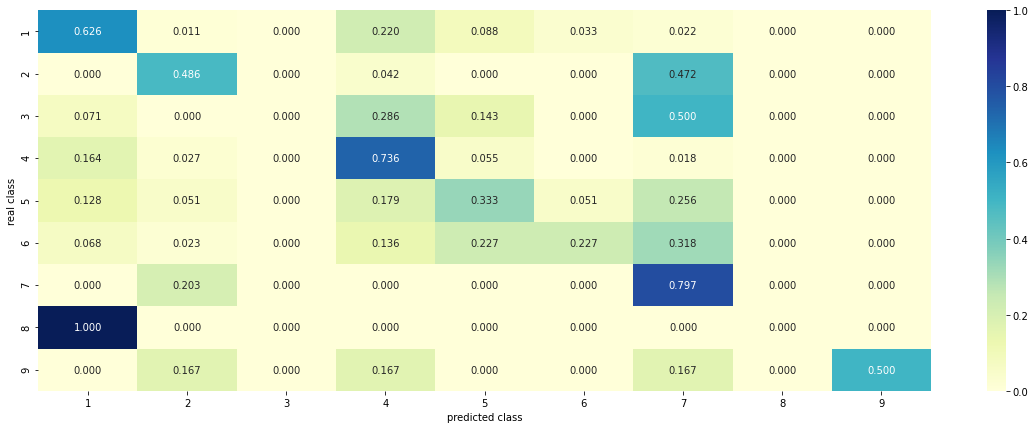

In [32]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)


There is a lack of interpretibility with the KNN model,as we can see below.

In [33]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 1
Actual Class : 7
The  99  nearest neighbours of the test points belongs to classes [7 2 2 6 7 6 7 7 5 5 7 2 7 7 2 7 2 7 7 7 7 7 7 2 7 7 7 2 7 7 2 2 7 6 7 2 7
 7 7 5 7 7 7 7 7 7 2 2 7 7 2 2 4 2 2 2 2 7 7 7 2 2 7 5 5 6 7 2 2 2 2 2 6 2
 7 7 7 7 7 2 7 2 7 7 7 5 7 7 5 7 7 7 5 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 57, 2: 28, 5: 8, 6: 5, 4: 1})


So KNN just predictes from heighboring classes and does not give much knowledge about feature importance.

**BALANCED LOGISTIC REGRESSION**

for alpha = 1e-06
Log Loss : 1.3899322732646124
for alpha = 1e-05
Log Loss : 1.3415924829871173
for alpha = 0.0001
Log Loss : 1.1974427687186695
for alpha = 0.001
Log Loss : 1.2441508232865115
for alpha = 0.01
Log Loss : 1.263551787273137
for alpha = 0.1
Log Loss : 1.2993720380430869
for alpha = 1
Log Loss : 1.4781881221138078
for alpha = 10
Log Loss : 1.5173277840195847
for alpha = 100
Log Loss : 1.5217166914734654


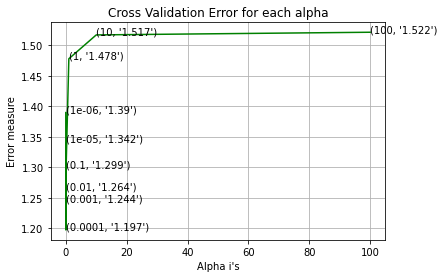

For values of best alpha =  0.0001 The train log loss is: 0.45995246826710656
For values of best alpha =  0.0001 The cross validation log loss is: 1.1974427687186695
For values of best alpha =  0.0001 The test log loss is: 1.008887768542192


In [34]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf1= CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf1.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf1.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf1.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1974427687186695
Number of mis-classified points : 0.37406015037593987
CONFUSION MATRIX


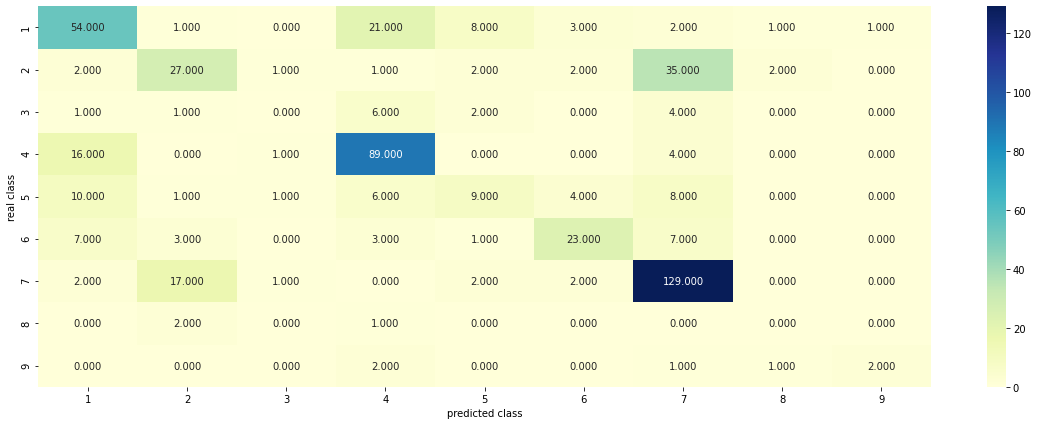

PRECISION MATRIX


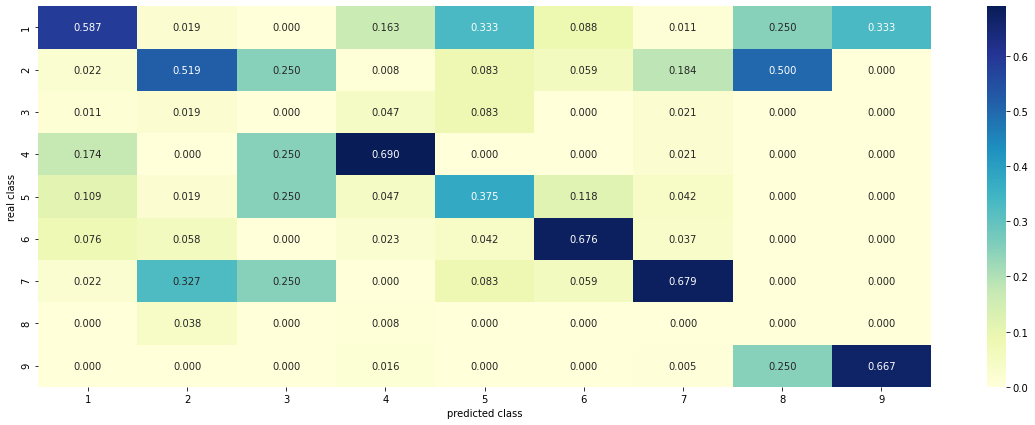

RECALL MATRIX


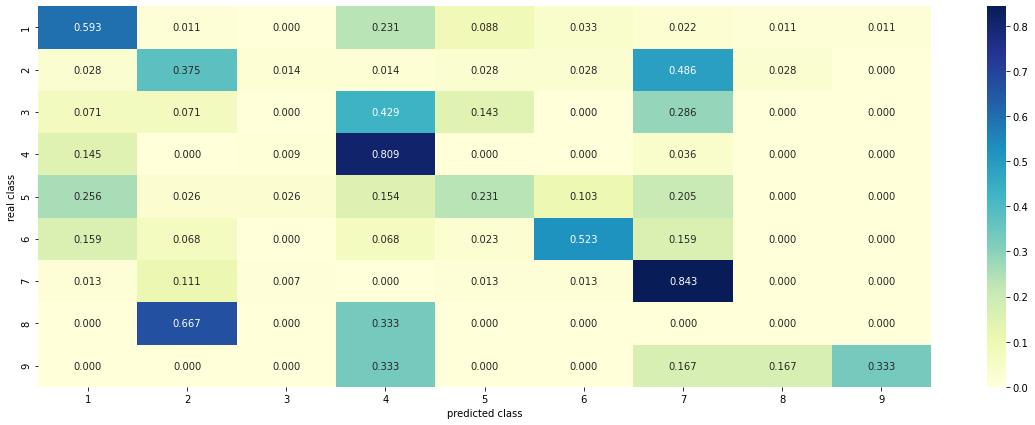

In [35]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


Here we can see in the matrices that the classes with lower number of data points are correctly classified.

Feature importance provided by logistic regression.

In [36]:
test_point_index = 3
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2107 0.217  0.0148 0.1738 0.0607 0.0218 0.2815 0.0164 0.0033]]
Actual Class : 4
--------------------------------------------------
303 Text feature [constitutive] present in test data point [True]
324 Text feature [continually] present in test data point [True]
377 Text feature [activation] present in test data point [True]
437 Text feature [oncogenes] present in test data point [True]
Out of the top  500  features  4 are present in query point


**IMBALANCED LOGISTIC REGRESSION**

for alpha = 1e-06
Log Loss : 1.3223915017747954
for alpha = 1e-05
Log Loss : 1.297428222013321
for alpha = 0.0001
Log Loss : 1.2132225562490098
for alpha = 0.001
Log Loss : 1.2209317787274676
for alpha = 0.01
Log Loss : 1.315318811324995
for alpha = 0.1
Log Loss : 1.4042880391918888
for alpha = 1
Log Loss : 1.540152851416522


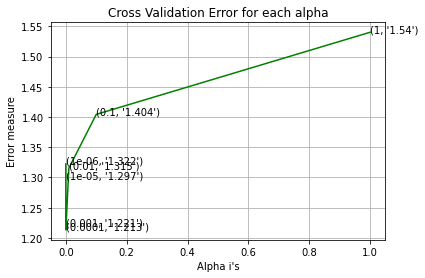

For values of best alpha =  0.0001 The train log loss is: 0.4384644008588402
For values of best alpha =  0.0001 The cross validation log loss is: 1.2132225562490098
For values of best alpha =  0.0001 The test log loss is: 1.0131976421921802


In [37]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2132225562490098
Number of mis-classified points : 0.37030075187969924
CONFUSION MATRIX


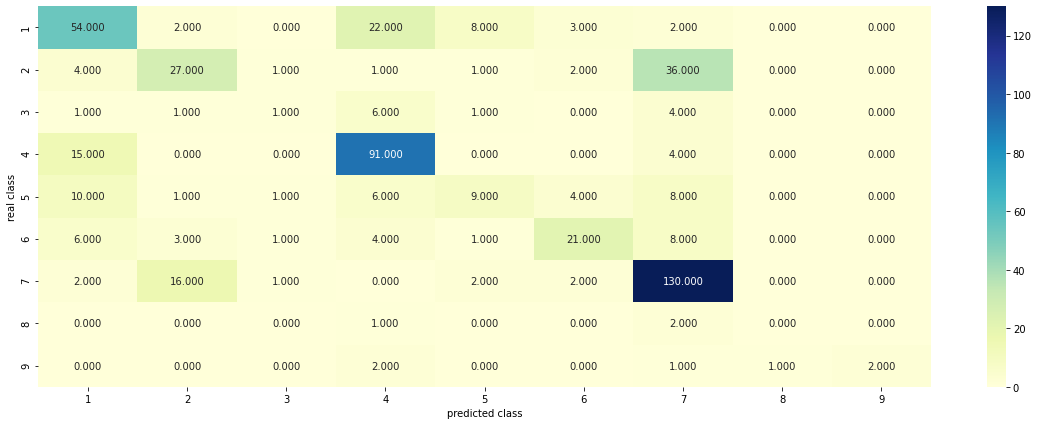

PRECISION MATRIX


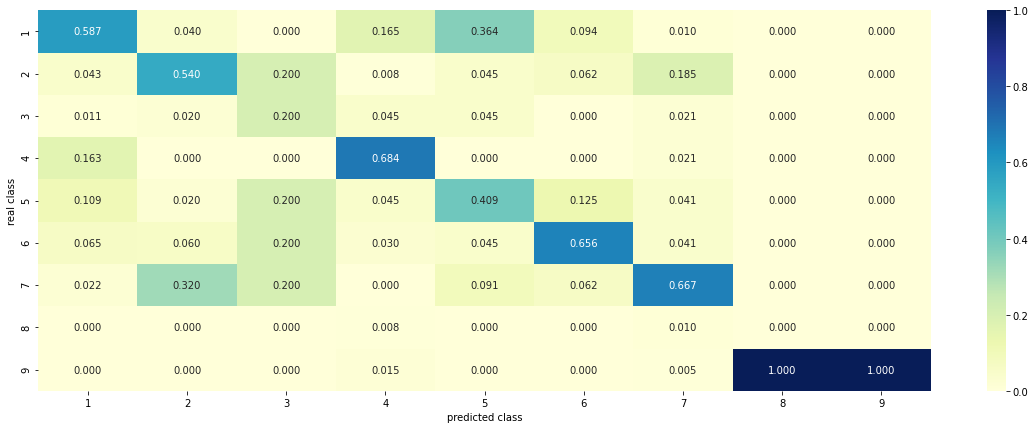

RECALL MATRIX


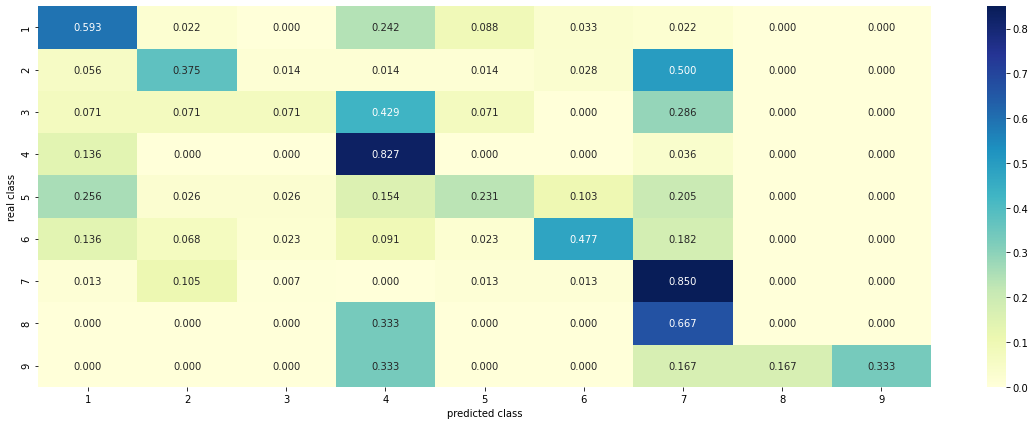

In [38]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


Here we can see in the matrices that the classes with lesser number of data points are incorrectly classified. So these matrices are also very important benchmark of our model success.

**LINEAR SUPPORT VECTOR CLASSIFIER**

In [39]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf2.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf2.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf2.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.3626855033700556
for C = 0.0001
Log Loss : 1.2993915258079982
for C = 0.001
Log Loss : 1.232975235610203
for C = 0.01
Log Loss : 1.2868324314140618
for C = 0.1
Log Loss : 1.4388391273357226
for C = 1
Log Loss : 1.5224660677473383
for C = 10
Log Loss : 1.522442617421578
for C = 100
Log Loss : 1.5224438424964495
For values of best alpha =  0.001 The train log loss is: 0.5148452814856119
For values of best alpha =  0.001 The cross validation log loss is: 1.232975235610203
For values of best alpha =  0.001 The test log loss is: 1.0479284111050213


Log loss : 1.232975235610203
Number of mis-classified points : 0.37781954887218044
CONFUSION MATRIX


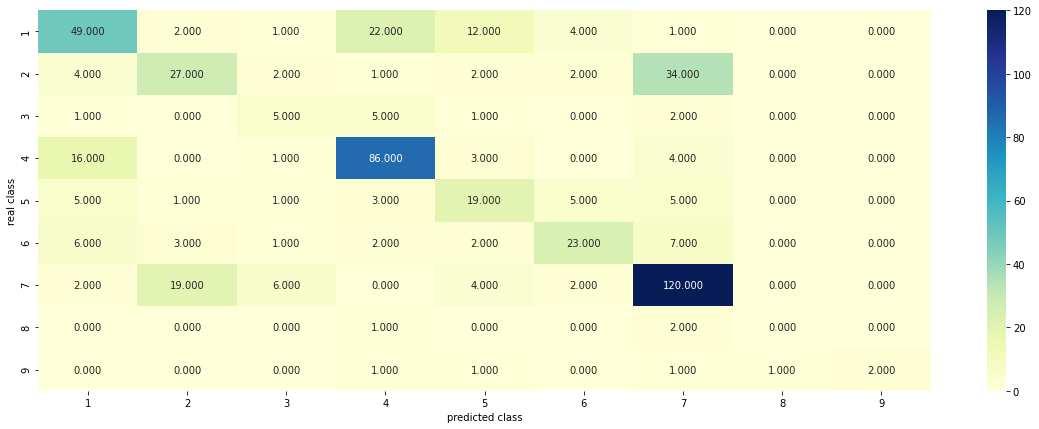

PRECISION MATRIX


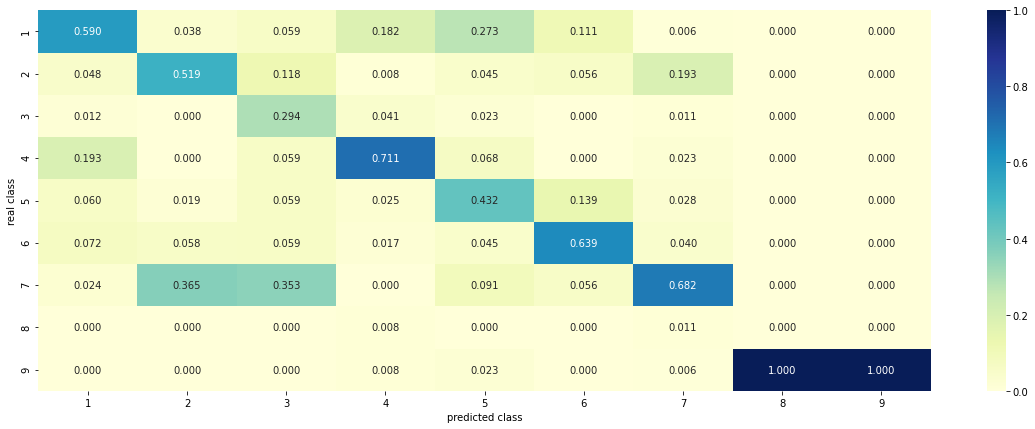

RECALL MATRIX


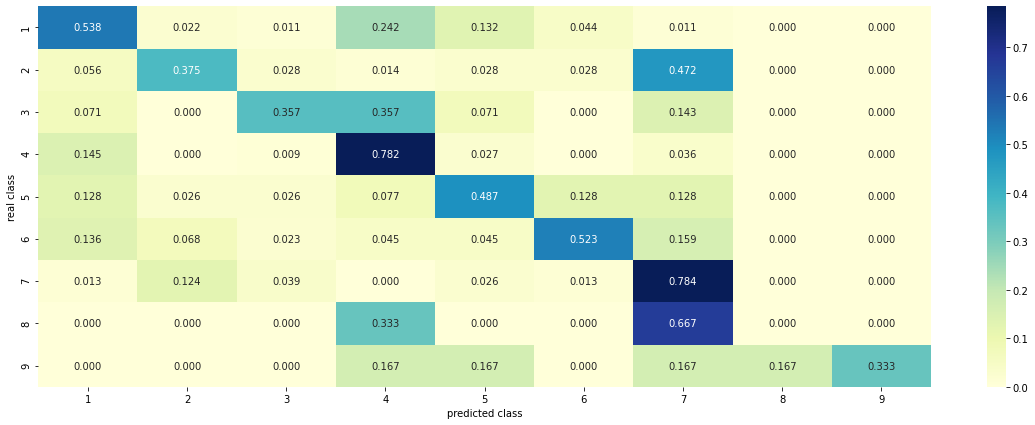

In [40]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)


In [41]:
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.1697 0.1899 0.0149 0.1375 0.0595 0.034  0.3826 0.008  0.0038]]
Actual Class : 7
--------------------------------------------------
317 Text feature [constitutive] present in test data point [True]
387 Text feature [activation] present in test data point [True]
Out of the top  500  features  2 are present in query point


In [50]:
from sklearn.ensemble import RandomForestClassifier
alpha = [500,1000]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf3= CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf3.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf3.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf3.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 500 and max depth =  5
Log Loss : 1.2907601487820652
for n_estimators = 500 and max depth =  10
Log Loss : 1.2316351551568323
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2865142433282424
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2315620258253526
For values of best estimator =  1000 The train log loss is: 0.6069064041864314
For values of best estimator =  1000 The cross validation log loss is: 1.2315620258253526
For values of best estimator =  1000 The test log loss is: 1.097466930930451


Log loss : 1.2315620258253526
Number of mis-classified points : 0.424812030075188
CONFUSION MATRIX


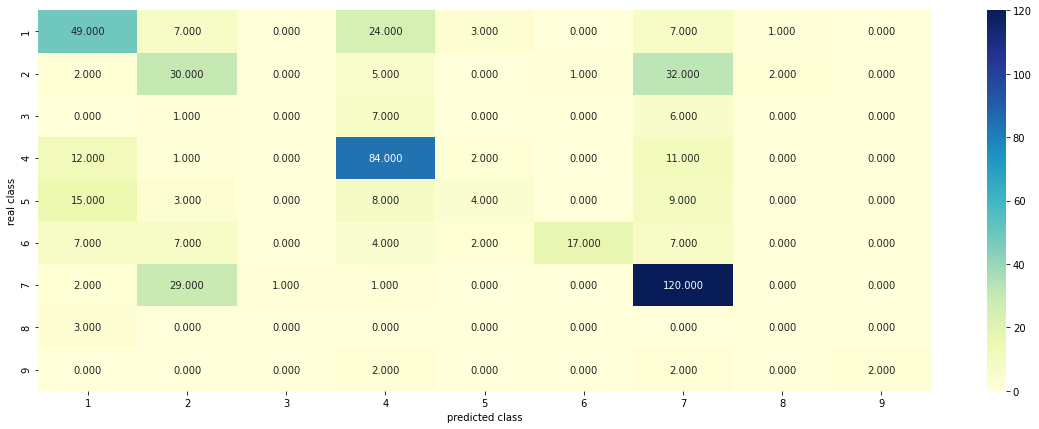

PRECISION MATRIX


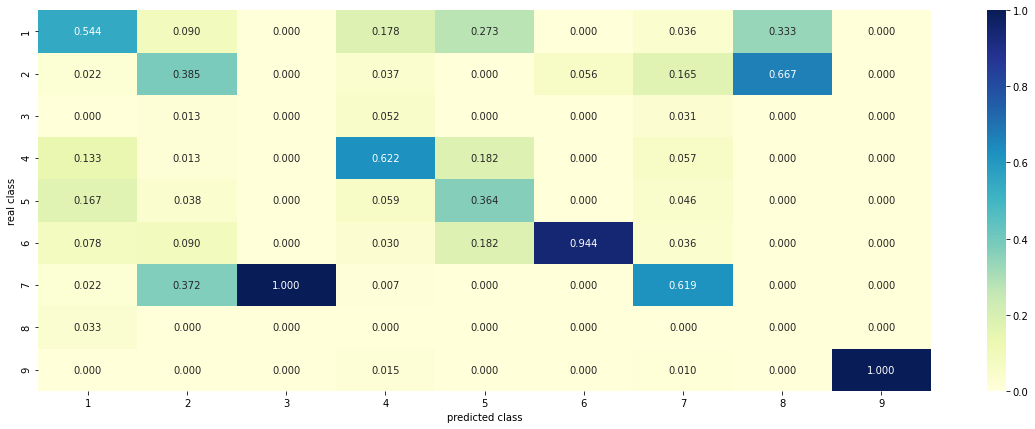

RECALL MATRIX


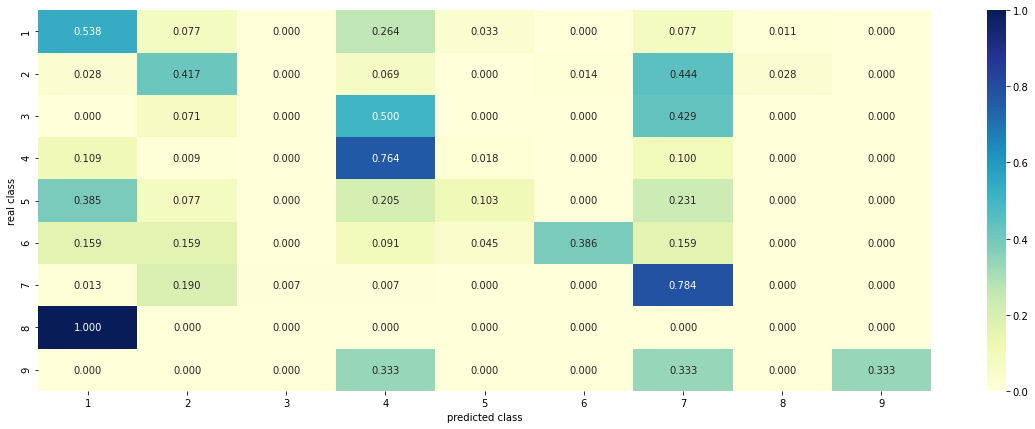

In [51]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)


In [52]:

test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.3759 0.0586 0.0172 0.3713 0.0539 0.0474 0.0603 0.0066 0.0088]]
Actual Class : 2
--------------------------------------------------
2 Text feature [activated] present in test data point [True]
8 Text feature [function] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
14 Text feature [loss] present in test data point [True]
20 Text feature [missense] present in test data point [True]
30 Text feature [treated] present in test data point [True]
32 Text feature [functional] present in test data point [True]
33 Text feature [activate] present in test data point [True]
37 Text feature [downstream] present in test data point [True]
39 Text feature [inhibition] present in test data point [True]
40 Text feature [protein] present in test data point [True]
45 Text feature [yeast] present in test data point [True]
46 Text feature [expressing] present in test data point [True]
59 Text feature [cell

In [54]:
from sklearn.ensemble import RandomForestClassifier
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf= RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0266525289311788
for n_estimators = 10 and max depth =  3
Log Loss : 1.6765066873369738
for n_estimators = 10 and max depth =  5
Log Loss : 1.5220993232023121
for n_estimators = 10 and max depth =  10
Log Loss : 1.8526661692720294
for n_estimators = 50 and max depth =  2
Log Loss : 1.6417013510200489
for n_estimators = 50 and max depth =  3
Log Loss : 1.4426808601425865
for n_estimators = 50 and max depth =  5
Log Loss : 1.3498952879678037
for n_estimators = 50 and max depth =  10
Log Loss : 1.736525422036892
for n_estimators = 100 and max depth =  2
Log Loss : 1.5668992121123222
for n_estimators = 100 and max depth =  3
Log Loss : 1.4825475140053554
for n_estimators = 100 and max depth =  5
Log Loss : 1.3103340403391353
for n_estimators = 100 and max depth =  10
Log Loss : 1.7172211783437448
for n_estimators = 200 and max depth =  2
Log Loss : 1.542365459979569
for n_estimators = 200 and max depth =  3
Log Loss : 1.4649079599808672

Here there was overfitting and the train and cv loss had no similarity even after hyperparameter tuning,we can see that cv loss is 20 times greater than train loss(while other have atmost twice).So this model will be rejected.

Log loss : 1.3103340403391353
Number of mis-classified points : 0.4642857142857143
CONFUSION MATRIX


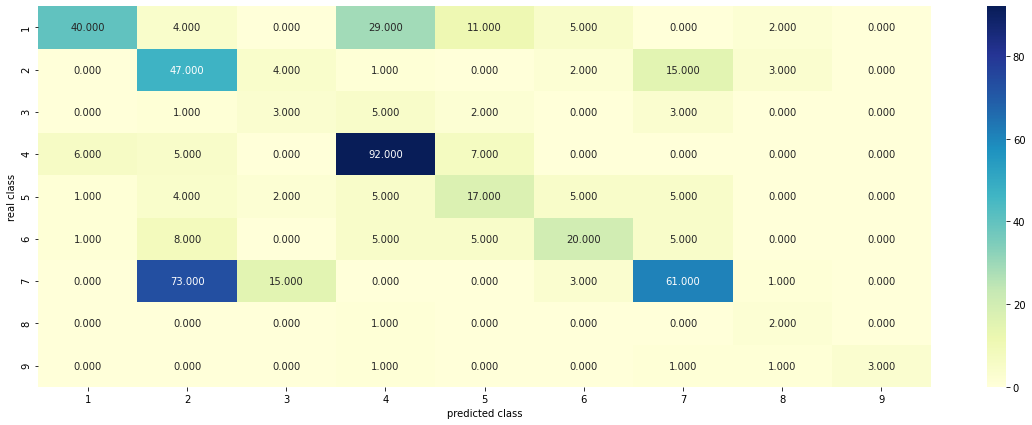

PRECISION MATRIX


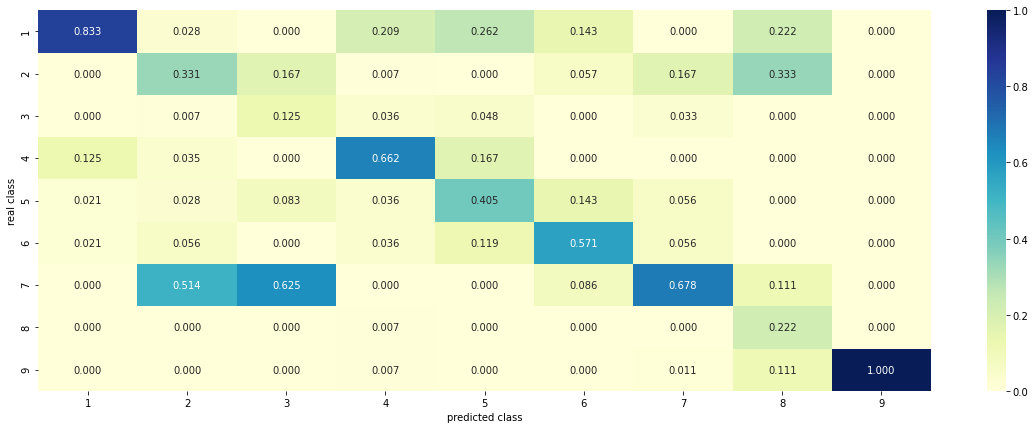

RECALL MATRIX


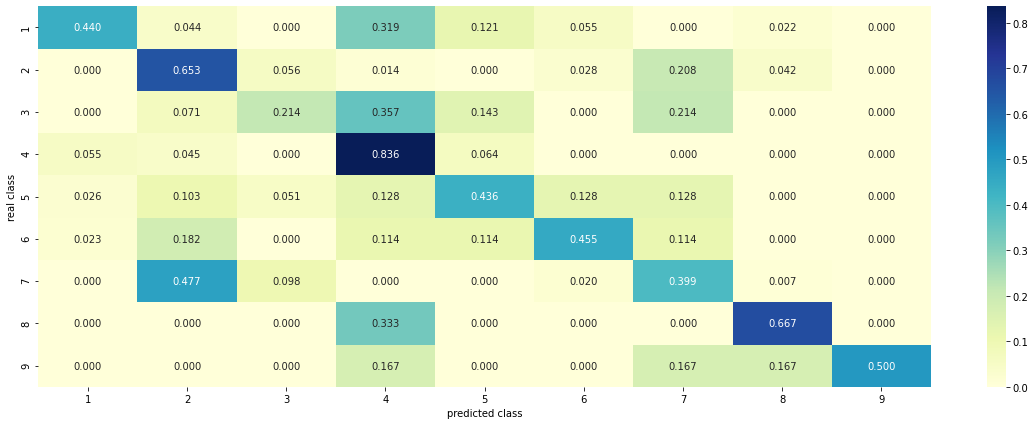

In [55]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)


In [56]:
test_point_index = 7
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

Predicted Class : 4
Predicted Class Probabilities: [[0.0829 0.0354 0.1475 0.5591 0.0408 0.0384 0.0108 0.0485 0.0365]]
Actual Class : 4
--------------------------------------------------


Also in response coding we cannot get the importance of each feature as we use probabilistic method of classification.

Finally we can also use another ensemble classifier like voting classifier(which will do majority voting classes predicted by each model) combining the logistic regression,linear support vector classifier and random forest.

*Here we have successfully have made the test logloss less than one and the missclaffied points are also close to 30 percent  which is the least we were able to achieve.*

Log loss (train) on the VotingClassifier : 0.5058587518745102
Log loss (CV) on the VotingClassifier : 1.1010173430660286
Log loss (test) on the VotingClassifier : 0.9723063820819762
Number of missclassified point : 0.31278195488721805
CONFUSION MATRIX


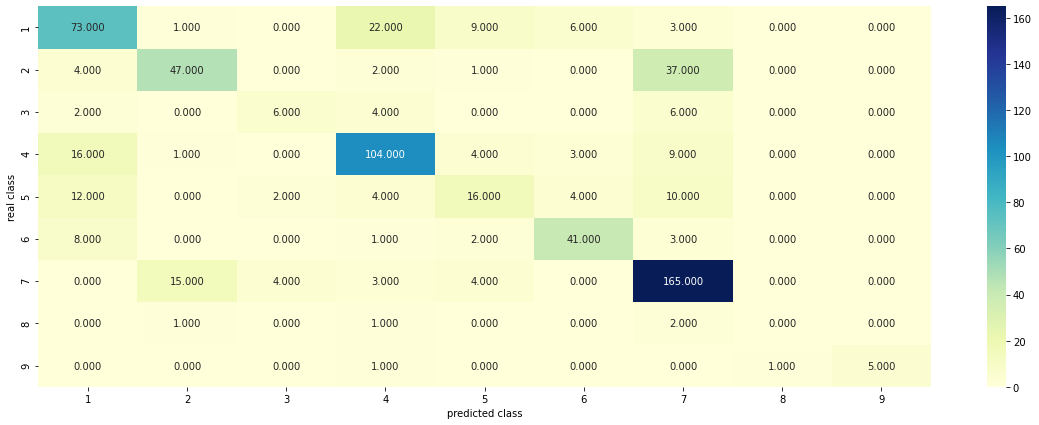

PRECISION MATRIX


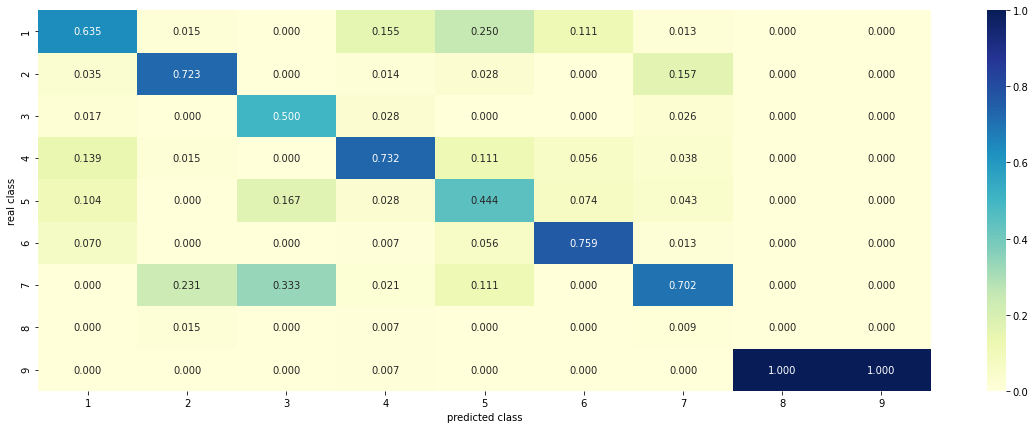

RECALL MATRIX


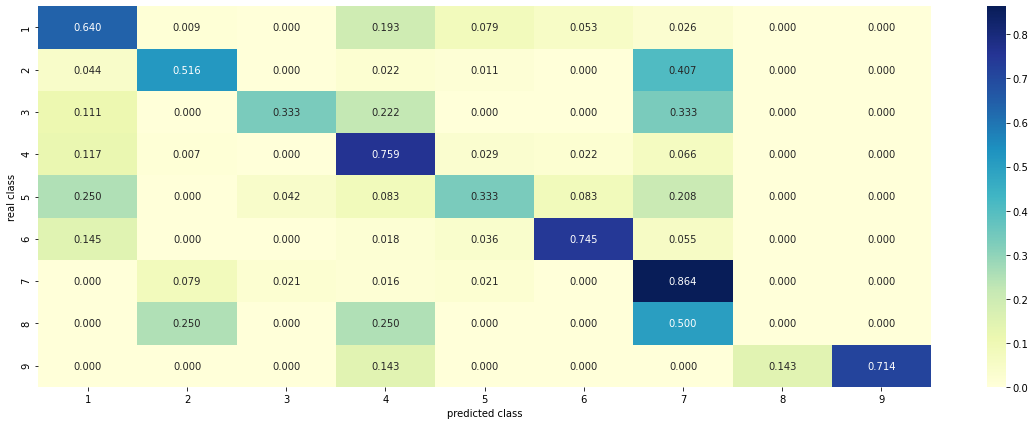

In [57]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))
